# Prevendo fraudes de cartão de crédito

A fraude de cartão de crédito é uma das principais causas de roubo de identidade em todo o mundo. As instituições financeiras empregam uma grande variedade de técnicas diferentes para prevenir fraudes, sendo uma das mais comuns a Regressão Logística.

Neste projeto, você é um Cientista de Dados que trabalha para uma empresa de cartão de crédito. Você tem acesso a um conjunto de dados, que representa um conjunto típico de transações de cartão de crédito. Sua tarefa é usar a regressão logística e criar um modelo preditivo para determinar se uma transação é fraudulenta ou não.

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Carregar os dados

**1.** O arquivo `Transações.csv` contém dados de 200 mil transações de cartão de crédito simuladas. Comece carregando os dados em um DataFrame pandas chamado `transacoes`. Imprima algumas linhas e a contagem total de linhas. 

In [3]:
transacoes = pd.read_csv('Transações.csv')
transacoes.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,8,CASH_OUT,158007.12,C424875646,0.00,0.00,C1298177219,474016.32,1618631.97,0
1,236,CASH_OUT,457948.30,C1342616552,0.00,0.00,C1323169990,2720411.37,3178359.67,0
2,37,CASH_IN,153602.99,C900876541,11160428.67,11314031.67,C608741097,3274930.56,3121327.56,0
3,331,CASH_OUT,49555.14,C177696810,10865.00,0.00,C462716348,0.00,49555.14,0
4,250,CASH_OUT,29648.02,C788941490,0.00,0.00,C1971700992,56933.09,86581.10,0
5,182,PAYMENT,15712.66,C365217190,13981.00,0.00,M1108542644,0.00,0.00,0
6,355,PAYMENT,357.15,C1752574405,283349.71,282992.56,M807801422,0.00,0.00,0
7,302,PAYMENT,19477.23,C1681583142,0.00,0.00,M911688965,0.00,0.00,0
8,35,PAYMENT,56554.20,C643126692,503065.44,446511.24,M1453972991,0.00,0.00,0
9,156,CASH_OUT,180660.51,C106721885,10044.00,0.00,C1944402764,32319.16,212979.67,0


### Limpe os dados

**2.** Olhando para o conjunto de dados, combinado com nosso conhecimento de transações de cartão de crédito em geral, podemos ver que existem algumas colunas interessantes para serem observadas. Sabemos que a coluna `amount`(quantia) de uma determinada transação será importante. Calcule estatísticas de resumo para esta coluna. Como é a distribuição?

In [4]:
transacoes['amount'].describe()

count    1.999990e+05
mean     1.802425e+05
std      6.255482e+05
min      0.000000e+00
25%      1.338746e+04
50%      7.426695e+04
75%      2.086376e+05
max      5.204280e+07
Name: amount, dtype: float64

**3.** Temos muitas informações sobre o tipo (`type`) de transação que estamos analisando. Crie uma nova coluna chamada `é_Pagamento` que atribui um `1` quando `type` é “PAYMENT” ou “DEBIT” e `0` caso de outro tipo.

In [5]:
def is_payment_condition(value):
    if value.lower() == 'payment' or value.lower() == 'debit':
        return 1
    return 0

transacoes['é_pagamento'] = transacoes['type'].apply(is_payment_condition)
transacoes['é_pagamento']

0         0
1         0
2         0
3         0
4         0
         ..
199994    1
199995    0
199996    0
199997    0
199998    0
Name: é_pagamento, Length: 199999, dtype: int64

**4.** Da mesma forma, crie uma coluna chamada `é_movimentação`, que capturará se o dinheiro saiu da conta de origem. Esta coluna terá um valor de 1 quando `type` for “CASH_OUT” ou “TRANSFER”, e 0 caso contrário.

In [6]:
def is_movement(value):
    if value.lower() == 'cash_out' or value.lower() == 'transfer':
        return 1
    return 0

transacoes['é_movimentação'] = transacoes['type'].apply(is_movement)
transacoes['é_movimentação']

0         1
1         1
2         0
3         1
4         1
         ..
199994    0
199995    1
199996    0
199997    0
199998    1
Name: é_movimentação, Length: 199999, dtype: int64

**5.** Em fraudes financeiras, outro fator fundamental a ser investigado seria a diferença de valor entre a conta de origem e a conta de destino. A hipótese, neste caso, é que contas de destino com valor significativamente diferente podem ser suspeitas de fraude. Vamos criar uma coluna chamada `diferençaContas` com a diferença absoluta das colunas `oldbalanceOrge` e `oldbalanceDest`

In [7]:
# Mantém os valores negativos
transacoes['diferençaContas'] = transacoes['oldbalanceOrg'] - transacoes['oldbalanceDest']

### Selecionar e dividir os dados

**6.** Antes de começarmos a treinar nosso modelo, precisamos definir nossos recursos (variáveis de entrada) e a coluna que será a saída. A saída neste conjunto de dados é a coluna `isFraud`. Crie uma variável chamada `x` que será um array composto pelos seguintes campos:

- `amount`
- `é_Pagamento`
- `é_movimentação`
- `diferençaContas`

Crie também uma variável chamada `y` com a coluna `isFraud`.

In [8]:
x = transacoes[['amount', 'é_pagamento', 'é_movimentação', 'diferençaContas']]
y = transacoes['isFraud']
print(x, y)

           amount  é_pagamento  é_movimentação  diferençaContas
0       158007.12            0               1       -474016.32
1       457948.30            0               1      -2720411.37
2       153602.99            0               0       7885498.11
3        49555.14            0               1         10865.00
4        29648.02            0               1        -56933.09
...           ...          ...             ...              ...
199994    1274.97            1               0         69376.00
199995  204041.98            0               1         40423.00
199996   66378.61            0               0       2588672.49
199997   87473.93            0               0       1429025.02
199998   97305.08            0               1         21328.00

[199999 rows x 4 columns] 0         0
1         0
2         0
3         0
4         0
         ..
199994    0
199995    0
199996    0
199997    0
199998    0
Name: isFraud, Length: 199999, dtype: int64


**7.** Divida os dados em conjuntos de treinamento e teste usando o método `train_test_split()` do `sklearn`. Usaremos o conjunto de treinamento para treinar o modelo e o conjunto de teste para avaliar o modelo. Use um `test_size` de 0.3.

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

### Normalize os dados

**8.** No `sklearn` a implementação da regressão logística utiliza regularização e portanto precisamos dimencionar nossas variáveis de entrada. Crie um objeto `StandardScaler` , Utilize `.fit_transform()` nas variáveis de entrada do conjunto de treinamento e `.transform()` nas variáveis de entrada do conjunto de de teste.

In [10]:
scale = StandardScaler()
x_train = scale.fit_transform(X=x_train)
x_test = scale.transform(X=x_test)
print(x_train, x_test)

[[-0.26042491  1.38046694 -0.87948064  0.06148876]
 [-0.21843999 -0.72439258 -0.87948064  0.02745481]
 [-0.23928012  1.38046694 -0.87948064  0.15566546]
 ...
 [-0.28632012  1.38046694 -0.87948064  0.17971574]
 [-0.25656426  1.38046694 -0.87948064  0.06148876]
 [-0.26904846  1.38046694 -0.87948064  0.06190599]] [[-0.0956018  -0.72439258  1.1370347   0.04357373]
 [-0.28330785  1.38046694 -0.87948064  0.08741016]
 [-0.28581875  1.38046694 -0.87948064  0.0663441 ]
 ...
 [-0.12563471 -0.72439258  1.1370347  -0.09988544]
 [ 0.02240581 -0.72439258  1.1370347   0.06591501]
 [-0.28280101  1.38046694 -0.87948064  0.06148876]]


### Criar e avaliar o modelo

**9.** Crie um modelo de regressão logística no `sklearn`.

In [11]:
logic_regression = LogisticRegression()
logic_regression.fit(X=x_train, y=y_train.values.ravel());
logic_regression

LogisticRegression()

**10.** Execute o método `.score()` do modelo nos dados de treinamento e imprima a pontuação de treinamento.

A pontuação do modelo nos dados de treinamento processará os dados de treinamento por meio do modelo treinado e preverá quais transações são fraudulentas. A pontuação retornada é a porcentagem de classificações corretas ou a precisão.

In [12]:
logic_regression.score(X=x_train, y=y_train)

0.9987999914285102

**11.** Imprima a matriz de confusão do modelo utilizando os dados do conjunto de teste.

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

predicts = logic_regression.predict(X=x_test)
confusion_matrix = confusion_matrix(y_test, predicts)
confusion_matrix

array([[59909,     1],
       [   87,     3]])

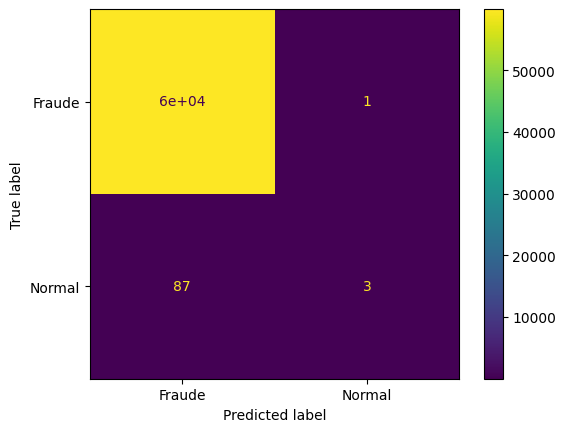

In [14]:
confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['Fraude', 'Normal'])
confusion_matrix_display.plot()

**12.** Execute o método `.score()` do modelo nos dados de teste e imprima a pontuação do teste.

A pontuação do modelo nos dados de teste processará os dados de teste por meio do modelo treinado e preverá quais transações são fraudulentas. A pontuação retornada é a porcentagem de classificações corretas, ou a precisão, e será um indicador do sucesso do seu modelo.

In [15]:
logic_regression.score(X=x_test, y=y_test)

0.9985333333333334

**13.** Imprima os coeficientes do modelo para ver a importância de cada variável para a previsão. Qual característica foi mais importante? Menos importante?

In [16]:
print(logic_regression.coef_, x.columns)

[[ 0.31451958 -0.65990234  8.91810732  3.01459348]] Index(['amount', 'é_pagamento', 'é_movimentação', 'diferençaContas'], dtype='object')


**R:** A característica mais relevante é a coluna de 'é_movimentação' e a menos relevante 'diferençaContas'

**14.** Vamos usar o modelo criado para processar mais transações que passaram por nossos sistemas. Existem três matrizes numpy abaixo com uma amostra com informações sobre novas transações “Novos dados de transação”

Crie uma quarta matriz, `minha_transacao` e adicione qualquer informação de transação que desejar. Certifique-se de inserir todos os valores como `floats`.

In [17]:
# Novos dados de transação

transacao1 = np.array([123456.78, 0.0, 1.0, 54670.1])
transacao2 = np.array([98765.43, 1.0, 0.0, 8524.75])
transacao3 = np.array([543678.31, 1.0, 0.0, 510025.5])

# Crie dados de uma nova transação
nova_transacao1 = np.array([99999.1, 0.0, 9000.0, 1000.0])
nova_transacao2 = np.array([780.1, 0.0, 700.0, 99999.0])


**15.** Combine as novas transações e a matriz que você criou (`minha_transacao`) em uma única matriz numpy chamada `conjunto_transacoes`.

In [18]:
conjunto_transacoes = np.array([transacao1, transacao2, transacao3, nova_transacao1, nova_transacao2])

**16.** Como o modelo de regressão logística foi treinado com dados padronizados, também devemos patronizar os dados sobre os quais estamos fazendo previsões. Usando o objeto `StandardScaler`  criado anteriormente, aplique o método `.transform()` na matriz `conjunto_transacoes` e salve o resultado em `conjunto_transacoes`.

In [19]:
conjunto_transacoes = scale.transform(conjunto_transacoes)

/home/xavier/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


**17.** Quais transações são fraudulentas? Use o método `.predict()` do seu modelo na matriz `conjunto_transacoes` e imprima o resultado para descobrir.

Quer ver as probabilidades que levaram a essas previsões? Chame o método `.predict_proba()` do seu modelo e imprima o resultado. A 1ª coluna é a probabilidade de uma transação não ser fraudulenta e a 2ª coluna é a probabilidade de uma transação ser fraudulenta (que foi calculada pelo modelo para tomar a decisão final de classificação).

In [20]:
predicts = logic_regression.predict(X=conjunto_transacoes)
predicts

array([0, 0, 0, 1, 1])

In [21]:
predicts_probability = logic_regression.predict_proba(X=conjunto_transacoes)
predicts_probability

array([[9.96169382e-01, 3.83061836e-03],
       [1.00000000e+00, 1.41931554e-11],
       [1.00000000e+00, 2.52767419e-11],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00]])